In [1]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import bert_ner
importlib.reload(bert_ner)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
import pandas as pd
from framework import DataCuration, FeatureEngineering
from bert_ner import TaskNER, FeatureEngineeringNER, BERTNER

# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)
ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahsaasbajaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahsaasbajaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set up the task details. This notebook handles NER (for labeling person and company names)

In [2]:
DATASET = 'w2' # supports w2 and resume

# also supports 'address' as 4th category in task
TASK_CONFIG = {
    'task': 'ner',
    'num_labels': 3,
    'labels_dict': {'person' : 0, 'org' : 1, 'none': 2}
}

task = TaskNER(TASK_CONFIG)

Set paths for datasets and goldens (local or ib, both work).
Specify configurations

In [3]:
# Path to publicly available W2 forms (Kaggle)
W2_DATA = [
   '/Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/ocr/out-pdf'
]
W2_GOLDEN = [
   '/Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/golden/goldens.csv'
]

GOLDEN_CONFIG = {
    'path': W2_GOLDEN,
    'is_local': True,
    'index_field_name':'File_BaseName',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': W2_DATA,
    'is_local': True, 
    'file_type': 'ibocr',
    'identifier': lambda path: os.path.basename(path).split('.ibocr')[0].split('.pdf')[0],
    'convert2txt': True
}

data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from /Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/ocr/out-pdf
INFO:root:1994 files loaded
INFO:root:Loading goldens from /Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/golden/goldens.csv
INFO:root:Total files Goldens: (2000, 45)
INFO:root:Total files found in the source with unique index: (1994, 45)
INFO:root:Processing 1994 IBOCR files to txt


In [4]:
assert(len(data.dataset.keys()) == data.golden.shape[0])

In [5]:
PROCESSING_CONFIG = {
    'X_DIST_THRESHOLD': 200,
    'RANDOM_SEQ_LEN': 5
}

# use as negative filter to generate random sequences
employer_address = ['Employer\'s Street Address', 'Employer\'s City-State-Zip']
employee_address = ['Employee Street Address', 'Employee\'s City-State-Zip']
other_location = ['Locality Name_1', 'State_1', 'Locality Name_2', 'State_2']

DATA_ARGS = {
    'task': task,
    'dataset': data,
    'candidates_fields': {
        'org':'Employer\'s Name',
        'person':'Employee Name',
        'address1': employer_address,
        'address2': employee_address,
        'address3': other_location
    },
    'use_random_seq': True, # if False, then use phrases generated by generate_candidates_phrases() for 'None' class in classifier training data
    'mode': 'person-org' # person-org or person-org-address, need to change label_dict in Task accordingly
}

data.generate_candidates_phrases(PROCESSING_CONFIG)
data.compare_candidates_and_goldens(DATA_ARGS['candidates_fields'])

INFO:root:Generating candidates for 1994 files
INFO:root:For X_DIST_THRESHOLD configuraion: 200
INFO:root:total files: 1994
person names found in candidates: 1987
org names found in candidates: 1992



In [6]:
data.split_train_test()

INFO:root:Total samples 1994, training samples: 1327, Test Samples: 667


Generate training data 

In [7]:
fe = FeatureEngineeringNER(DATA_ARGS)
train_data, test_data = fe.create_train_test_data(PROCESSING_CONFIG)
train_data.head(20)

INFO:root:Generating labeled data for dataset with shape (1327, 45)
INFO:root:Cleaned text size 1327
INFO:root:Random Sequence text size 1327
INFO:root:Mode person-org
INFO:root:Generating labeled data for dataset with shape (667, 45)
INFO:root:Cleaned text size 667
INFO:root:Random Sequence text size 667
INFO:root:Mode person-org
INFO:root:train data: (3981, 2), test test: (2001, 2)


,context,label
641,Zachary Reynolds,0
527,f address ZIP code,2
1135,Park-Cruz PLC,1
672,Webb-Davis PLC,1
1154,Miles-Howard and Sons,1
269,Hudson Ltd Group,1
1172,Daugherty Ltd Ltd,1
407,b Employer identification number compensation,2
379,"Hayes, Carter and Dennis Group",1
722,Brian Alvarado,0


Optionally, Generate training dataset from public names (of persons and companies). This only supports 'person-org' and has no addresses. This uses candidates generated by generate_candidates_phrases()

In [8]:
DATA_ARGS_PUBLIC = {
    'task': task,
    'filepaths': {
        'org':'/Users/ahsaasbajaj/Documents/Data/names/companies_sorted.csv',
        'person1':'/Users/ahsaasbajaj/Documents/Data/names/first_names.all.txt',
        'person2': '/Users/ahsaasbajaj/Documents/Data/names/last_names.all.txt',
        'none': '/Users/ahsaasbajaj/Documents/Data/names/none_phrases200.csv' # generated from datacuration.candidates with person, org, address filtered out as in FeatureEngineeringNER().create_train_test_data
    },
    'name_field': {
        'person': 'name', # field name inside text files or csv
        'org': 'name',
        'none': 'context'
    },

    'mode': 'person-org' # person-org or person-org-address, need to change label_dict in Task accordingly
}

In [9]:
train_data_public, test_data_public = FeatureEngineeringNER.create_train_test_data_from_files(DATA_ARGS_PUBLIC)
train_data_public.head(10)

INFO:root:Total 7173426 company names available
INFO:root:Total 164432 first names, 98391 last names available
INFO:root:Total 44738 none phrases available
INFO:root:Selecting minimum of three categories available, min count: 44738
INFO:root:Total samples 134213, training samples: 94072, Test Samples: 40141


,context,label
40924,shobhna mccamey,0
122373,social security wages,2
84180,liberty safes of san jose,1
53113,partners gin,1
7112,oluwadamilare hargest,0
119976,22705 wise squares apt. 168,2
76264,hyperionit private limited,1
19241,ryland ewbank,0
60017,the earth home,1
90399,"c employer's name, address, and zip code",2


Specify configuration for finetuning BERT

In [10]:
# For Debugging
train_data = FeatureEngineering.get_subset_for_debugging(train_data, sample_size=20)
test_data = FeatureEngineering.get_subset_for_debugging(test_data, sample_size=10)

INFO:root:Finetuning BERT Model
INFO:root:outDir: ../models/bert_classifier, trainFile: (20, 2), devFile: (10, 2), testFile: (10, 2)
INFO:root:Device cpu, GPU False, epochs: 4, batch_size: 32
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]INFO:root:Training for 1 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.1966
INFO:root:Training Accuracy: 0.2000
INFO:root:Validation Accuracy: 0.2000
Epoch:  25%|██▌       | 1/4 [00:45<02:15, 45.02s/it]INFO:root:Training for 2 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.2542
INFO:root:Training Accuracy: 0.3000
INFO:root:Validation Accuracy: 0.2000
Epoch:  50%|█████     | 2/4 [01:34<01:32, 46.37s/it]INFO:root:Training for 3 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.1050
INFO:root:Training Accuracy: 0.4000
INFO:root:Validation Accuracy: 0.2000
Epoch:  75%|███

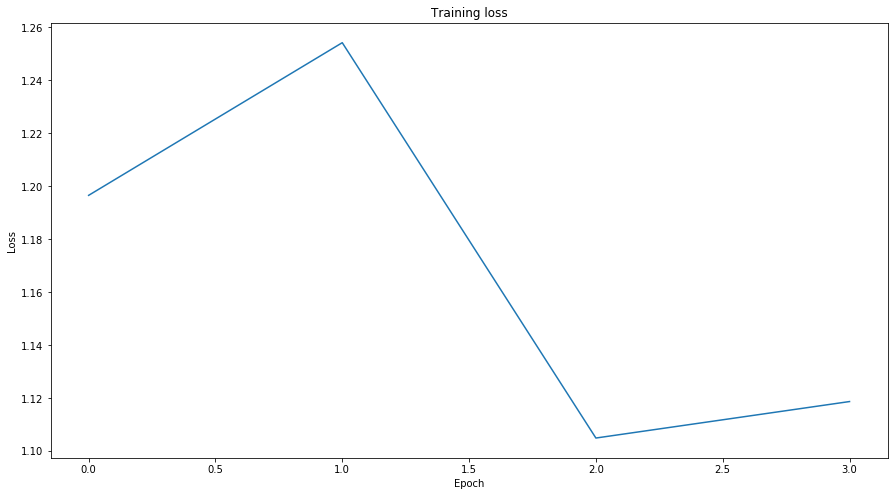

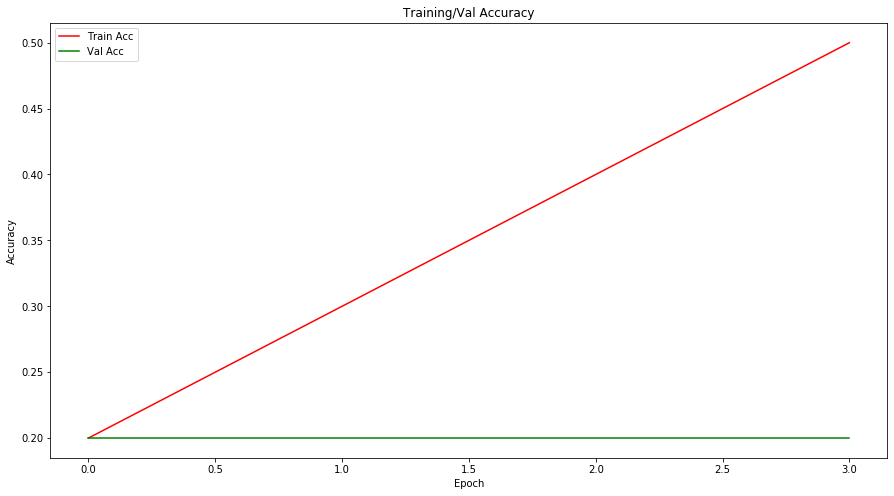

In [11]:
TRAINING_ARGS = {
    'outputDir': '../models/bert_classifier',
    'trainFile': train_data,
    'devFile': test_data,
    'testFile': test_data,
    'gpu': False,
    'model_name_or_path': 'bert-large-cased',
    'num_labels': TASK_CONFIG['num_labels'],
    'epochs': 4,
    'batch_size': 32
}

model = BERTNER(DATA_ARGS, TRAINING_ARGS)
model.train()